# Analysis On Dome Thermal Properties 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set_context('paper')

In [3]:
from datetime import date
date = date.today().strftime("%d-%m-%Y")
print(f'Today is: {date}')

Today is: 20-04-2024


In [4]:
%matplotlib inline

In [58]:
def convert_to_hour_only(df):
    df['night_t0'] = pd.to_datetime(pd.Series(df['night_t0']),utc=True)

    # Assuming 'DATE' column is already a datetime dtype
    df['night_t0'] = df['night_t0'].dt.hour + df['night_t0'].dt.minute / 60
    return df

def compute_time_diff(df):
    df['night_t0'] = pd.to_datetime(pd.Series(df['night_t0']),utc=True)
    return (df.DATE - df['night_t0']).dt.total_seconds() / 3600

In [59]:
# df['night_t0'] = pd.to_datetime(pd.Series(df['night_t0']),utc=True)


## Load The Data

In [61]:
import pandas as pd
df = pd.read_csv('../gaia_matched_april2024_PREOPS-4985.csv', index_col=0)
df['DATE'] = pd.to_datetime(df['DATE'],utc=True)
df['eps_time'] = compute_time_diff(df)
df = convert_to_hour_only(df)

flagG = (df.ref_mag_g>14)&(df.ref_mag_g<17)
flagSNR = (df.snr>50)
flagT = flagG&flagSNR

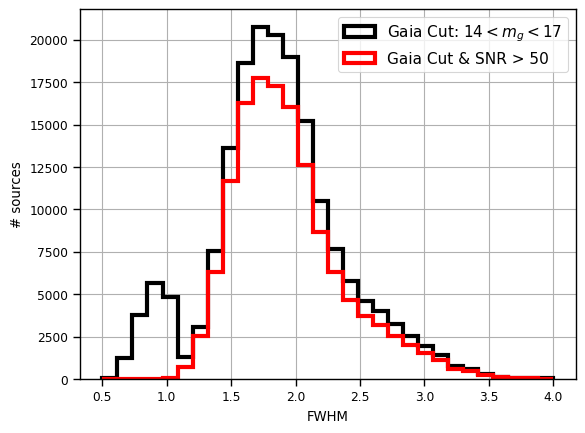

In [62]:
l1 = r'Gaia Cut: $ 14 < m_g < 17$'
l2 = r'Gaia Cut & SNR > 50'

df.fwhm[flagG].hist(bins=np.linspace(0.5, 4., 31),histtype='step',lw=3, color='k',label=l1)
df.fwhm[flagT].hist(bins=np.linspace(0.5, 4., 31),histtype='step',lw=3, color='r',label=l2)
# plt.yscale('log')
plt.xlabel('FWHM')
plt.ylabel('# sources')
plt.legend(fontsize=11)

In [63]:
dstar = df[flagT].copy()

# Assuming dstar is your DataFrame and 'DATE' is the datetime column
# Convert 'DATE' column to datetime dtype if needed
dstar['DATE'] = pd.to_datetime(dstar['DATE'])

# Set 'DATE' column as the index
dstar.set_index('DATE', inplace=True)

# Localize the datetime index to UTC
dstar.index = dstar.index.tz_localize('UTC')

# Convert the datetime index to the desired timezone (America/Santiago)
dstar.index = dstar.index.tz_convert('America/Santiago')

TypeError: Already tz-aware, use tz_convert to convert.

## Plot Functions

In [ ]:
def plot_binned_data(df, xcol, ycol, bins, color=None, label=None):    
    # Group data by bins
    groups = df.groupby(pd.cut(df[xcol], bins))
    
    # Calculate mean and standard deviation for each bin
    bin_means = groups[ycol].mean()
    bin_stds = groups[ycol].std()
    
    # Extract bin edges for plotting
    bin_edges = 0.5*(bins[1:]+bins[:-1])
    
    # Plot binned data with error bars
    plt.errorbar(bin_edges, bin_means, yerr=bin_stds, color=color,
                 fmt='o', capsize=5, label=label)
    
    # Add labels and title
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    

In [ ]:
colors = ['k','grey','r','b']

In [ ]:
dstar.columns

## Preliminary Results

In [ ]:
first_half = dstar.night_period==1
sec_half = dstar.night_period==2
th_half = dstar.night_period==3
last_half = (dstar.night_period==4)|(dstar.night_period==5)


### Average FWHM Timeline

In [64]:
dstar['DAY'] = np.array([str(eid)[:8] for eid in dstar.EXPID.to_numpy()]).astype(np.int64)

In [65]:
# df.set_index('DATE')

In [66]:
# fwhm = dstar[['fwhm']].loc[last_half|th_half].dropna().copy()
# .loc[first_half|sec_half]
def get_timeline(df,col='fwhm'):
    fwhm = df[[col]].dropna().copy()
    
    # Resample the 'fwhm' column to daily frequency
    daily_fwhm = fwhm.resample('D')
    
    # Calculate the mean and std
    dstats = daily_fwhm.agg(['mean', 'std'])

    d = dstats[col].index
    m = dstats[col]['mean'].to_numpy()
    e = dstats[col]['std'].to_numpy()
    return d, m, e

In [67]:
plt.figure(figsize=(10,4))

d, m, e = get_timeline(dstar.loc[first_half|sec_half])
plt.scatter(d, m)
plt.errorbar(d, m, yerr=e, capsize=2)

d, m, e = get_timeline(dstar.loc[dstar.night_period>2])
plt.scatter(d, m)
plt.errorbar(d, m, yerr=e, capsize=2)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

<Figure size 1000x400 with 0 Axes>

In [ ]:
# dstar[['fwhm']]

### Average FWHM Per Exposure

In [68]:
# eid = 2024030800520
# mask = dstar.EXPID==eid
# de = dstar.loc[mask]

# plt.scatter(dstar.ref_mag_g, dstar.fwhm, alpha=0.3)
# plt.ylim(0.,5.)

In [70]:
mycols = ['fwhm', 'EXPID', 'eps_time',
          'elevation0', 'azimuth0', 'speed', 'night_t0', 'night_period', 
          'sonicTemperature', 'sonicTemperatureStdDev', 'speed0', 'speed1',
          'speed2', 'temperatureItem0', 'temperatureItem1', 'temperatureItem2',
          'temperatureItem3', 'temperatureItem4', 'deltaTempM1M2',
          'deltaTempM1M2_night_t0_value', 'deltaTempM1M2_day_value',
          'deltaTempM1M2_day_time', 'M2_night_t0_value', 'M2_day_value',
          'M2_day_time']

de = dstar[mycols].groupby('EXPID').agg(['mean', 'std'])

In [71]:
import pandas as pd

# Group by 'EXPID' and calculate mean and std for specified columns
de = dstar[mycols].groupby('EXPID').agg(['mean', 'std'])

# Flatten hierarchical column index
de.columns = ['{}_{}'.format(col, stat) for col, stat in de.columns]

# filter exposures
de = de.loc[de.fwhm_std < 0.5]

# Extract only the desired columns
# de = de[['fwhm_mean', 'fwhm_std', 'sonicTemperatureStdDev_mean', 'sonicTemperatureStdDev_std']]

In [72]:
de['DATE'] = 0
index = [dstar.loc[dstar['EXPID'] == eid].index[0] for eid in de.index]

# Iterate over each row in de and assign the corresponding datetime value
for eid, date_value in zip(de.index, index):
    de.loc[eid, 'DATE'] = date_value

# Convert 'DATE' column to datetime dtype
de['DATE'] = pd.to_datetime(de['DATE'])
de['EXPID'] = de.index
de.columns = [col.replace('_mean', '') for col in de.columns]

# Set 'DATE' column as the index
de.set_index('DATE', inplace=True)


/tmp/ipykernel_9086/1989421089.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-05-12 01:09:11.424000+00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  de.loc[eid, 'DATE'] = date_value


In [ ]:
    
de.to_csv('../gaia_matched_april2024_PREOPS-4985_fwhm_exp_averaged.csv', index=True)


In [ ]:
# plt.scatter(de.fwhm, de.elevation0)

In [25]:
first_half = de.night_period==1
sec_half = de.night_period==2
th_half = de.night_period==3
last_half = (de.night_period==4)|(de.night_period==5)


/tmp/ipykernel_9086/2892656373.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(pd.cut(df[xcol], bins))


Text(0.5, 0, 'Temp M1 - Temp M2 [deg C] ')

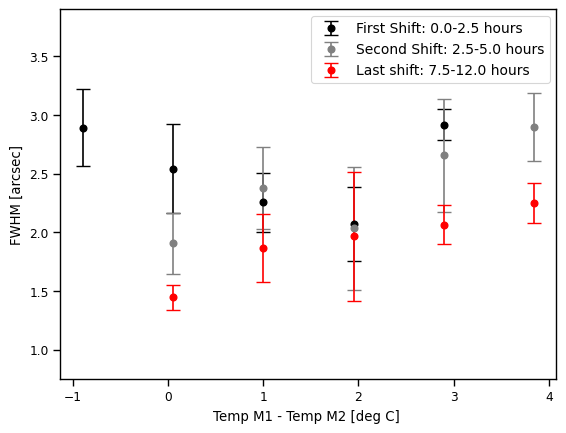

In [26]:
pl, ph = np.nanpercentile(dstar.deltaTempM1M2, [0.01,99.99])
dtbins = np.linspace(pl, ph, 7)

plot_binned_data(de.loc[first_half], 'deltaTempM1M2', 'fwhm', dtbins, color=colors[0], label='First Shift: 0.0-2.5 hours')
plot_binned_data(de.loc[sec_half], 'deltaTempM1M2', 'fwhm', dtbins, color=colors[1], label='Second Shift: 2.5-5.0 hours')
plot_binned_data(de.loc[last_half], 'deltaTempM1M2', 'fwhm', dtbins, color=colors[2], label='Last shift: 7.5-12.0 hours')

plt.ylim(0.75,3.9)
plt.ylabel('FWHM [arcsec]')
plt.legend(fontsize=10)
plt.xlabel(r'Temp M1 - Temp M2 [deg C] ')
# plt.title('During Exposure')

Text(0, 0.5, 'Mean Average Per Exposure')

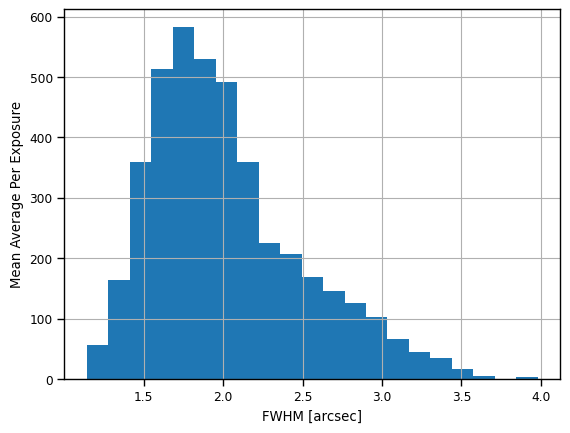

In [27]:
de.fwhm.hist(bins=21)
plt.xlabel('FWHM [arcsec]')
plt.ylabel('Mean Average Per Exposure')

<ErrorbarContainer object of 3 artists>

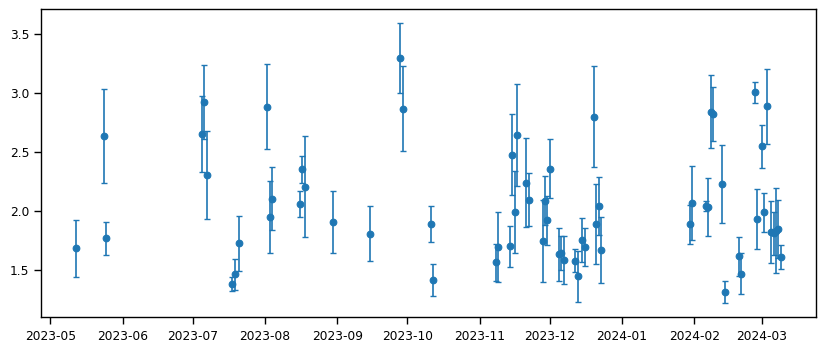

In [28]:
plt.figure(figsize=(10,4))

d, m, e = get_timeline(de,'fwhm')
plt.scatter(d, m)
plt.errorbar(d, m, yerr=e, capsize=2, fmt='o', markersize=0)

In [29]:
de.columns = [col.replace('_mean', '') for col in de.columns]


### Temperature Gradient Between The Mirrors

In [31]:
# pl, ph = np.nanpercentile(dstar.deltaTempM1M2, [0.01,99.99])
# dtbins = np.linspace(pl, ph, 7)

# plot_binned_data(dstar.loc[first_half], 'deltaTempM1M2', 'fwhm', dtbins, color=colors[0], label='First Shift: 0.0-2.5 hours')
# plot_binned_data(dstar.loc[sec_half], 'deltaTempM1M2', 'fwhm', dtbins, color=colors[1], label='Second Shift: 2.5-5.0 hours')
# plot_binned_data(dstar.loc[last_half], 'deltaTempM1M2', 'fwhm', dtbins, color=colors[2], label='Last shift: 7.5-12.0 hours')

# plt.ylim(0.75,3.9)
# plt.ylabel('FWHM [arcsec]')
# plt.legend(fontsize=10)
# plt.xlabel(r'Temp M1 - Temp M2 [deg C] ')
# # plt.title('During Exposure')

In [ ]:
pl, ph = np.nanpercentile(dstar.sonicTemperatureStdDev, [0.01,99.99])
sbins = np.linspace(pl, ph, 7)

plot_binned_data(de.loc[first_half], 'sonicTemperatureStdDev', 'deltaTempM1M2', sbins, color=colors[0], label='First Shift: 0.0-2.5 hours')
plot_binned_data(de.loc[last_half], 'sonicTemperatureStdDev', 'deltaTempM1M2', sbins, color=colors[2], label='Last shift: 7.5-10 hours')

# plt.ylim(0.75,3.75)
# plt.ylabel('FWHM [arcsec]')
plt.legend(fontsize=10)
plt.xlabel(r'$\sigma(T_{\rm sonic})$')
# plt.xlabel(r'Temp M1 - Temp M2 [deg C] ')
# plt.title('During Exposure')

In [ ]:
pl, ph = np.nanpercentile(dstar.deltaTempM1M2, [0.01,99.99])
dtbins = np.linspace(pl, ph, 7)

plot_binned_data(dstar.loc[first_half], 'deltaTempM1M2', 'fwhm', dtbins, color=colors[0], label='First Shift: 0.0-2.5 hours')
plot_binned_data(dstar.loc[sec_half], 'deltaTempM1M2', 'fwhm', dtbins, color=colors[1], label='Second Shift: 2.5-5.0 hours')
plot_binned_data(dstar.loc[last_half], 'deltaTempM1M2', 'fwhm', dtbins, color=colors[2], label='Last shift: 7.5-12.0 hours')

plt.ylim(0.75,3.9)
plt.ylabel('FWHM [arcsec]')
plt.legend(fontsize=10)
plt.xlabel(r'Temp M1 - Temp M2 [deg C] ')
# plt.title('During Exposure')

In [ ]:
pl, ph = np.nanpercentile(dstar.sonicTemperatureStdDev, [0.01,99.99])
sbins = np.linspace(pl, ph, 7)

plot_binned_data(de.loc[first_half], 'sonicTemperatureStdDev', 'fwhm', sbins, color=colors[0], label='First Shift: 0.0-2.5 hours')
plot_binned_data(de.loc[last_half], 'sonicTemperatureStdDev', 'fwhm', sbins, color=colors[2], label='Last shift: 7.5-10 hours')

plt.ylim(0.75,3.75)
plt.ylabel('FWHM [arcsec]')
plt.legend(fontsize=10)
plt.xlabel(r'$\sigma(T_{\rm sonic})$')
# plt.xlabel(r'Temp M1 - Temp M2 [deg C] ')
# plt.title('During Exposure')

### Local Turbulence

In [ ]:
pl, ph = np.nanpercentile(dstar.sonicTemperatureStdDev, [0.01,99.99])
sbins = np.linspace(pl, ph, 7)

plot_binned_data(dstar.loc[first_half], 'sonicTemperatureStdDev', 'fwhm', sbins, color=colors[0], label='First Shift: 0.0-2.5 hours')
plot_binned_data(dstar.loc[last_half], 'sonicTemperatureStdDev', 'fwhm', sbins, color=colors[2], label='Last shift: 7.5-10 hours')

plt.ylim(0.75,3.75)
plt.ylabel('FWHM [arcsec]')
plt.legend(fontsize=10)
plt.xlabel(r'$\sigma(T_{\rm sonic})$')
# plt.xlabel(r'Temp M1 - Temp M2 [deg C] ')
# plt.title('During Exposure')